In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc

In [2]:
BASE_PATH = Path('/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet')

train_ds = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet')
    for i in range(10)
])

In [3]:
parts = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet') \
        .select(['date_id', 'time_id', 'symbol_id']) \
        .with_columns(pl.lit(i).cast(pl.Int8).alias('part')).collect()
    for i in range(10)
])
parts.head()

shape: (5, 4)
┌─────────┬─────────┬───────────┬──────┐
│ date_id ┆ time_id ┆ symbol_id ┆ part │
│ ---     ┆ ---     ┆ ---       ┆ ---  │
│ i16     ┆ i16     ┆ i8        ┆ i8   │
╞═════════╪═════════╪═══════════╪══════╡
│ 0       ┆ 0       ┆ 1         ┆ 0    │
│ 0       ┆ 0       ┆ 7         ┆ 0    │
│ 0       ┆ 0       ┆ 9         ┆ 0    │
│ 0       ┆ 0       ┆ 10        ┆ 0    │
│ 0       ┆ 0       ┆ 14        ┆ 0    │
└─────────┴─────────┴───────────┴──────┘

In [4]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)]).collect()
responders.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 1         ┆ 0.738489   ┆ … ┆ 1.218368   ┆ 0.775981   ┆ 0.346999  ┆ 0.095504  │
│ 0       ┆ 0       ┆ 7         ┆ 2.965889   ┆ … ┆ 5.0        ┆ 0.703665   ┆ 0.216683  ┆ 0.778639  │
│ 0       ┆ 0       ┆ 9         ┆ -0.864488  ┆ … ┆ 0.099793   ┆ 2.109352   ┆ 0.670881  ┆ 0.772828  │
│ 0       ┆ 0       ┆ 10        ┆ 0.408499   ┆ … ┆ 1.225376   ┆ 1.114137   ┆ 0.775199  ┆ -1.379516 │
│ 0       ┆ 0       ┆ 14        ┆ -0.373387  ┆ … ┆ -5.0       ┆ -3.57282   ┆ -1.089123 ┆ -5.0      │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [5]:
train_ds = train_ds.collect()

In [6]:
train_ds.head()

shape: (5, 92)
┌─────────┬─────────┬───────────┬──────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ weight   ┆ … ┆ responder_ ┆ responder_ ┆ responder_ ┆ responder_ │
│ ---     ┆ ---     ┆ ---       ┆ ---      ┆   ┆ 5          ┆ 6          ┆ 7          ┆ 8          │
│ i16     ┆ i16     ┆ i8        ┆ f32      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│         ┆         ┆           ┆          ┆   ┆ f32        ┆ f32        ┆ f32        ┆ f32        │
╞═════════╪═════════╪═══════════╪══════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 0       ┆ 1         ┆ 3.889038 ┆ … ┆ 1.218368   ┆ 0.775981   ┆ 0.346999   ┆ 0.095504   │
│ 0       ┆ 0       ┆ 7         ┆ 1.370613 ┆ … ┆ 5.0        ┆ 0.703665   ┆ 0.216683   ┆ 0.778639   │
│ 0       ┆ 0       ┆ 9         ┆ 2.285698 ┆ … ┆ 0.099793   ┆ 2.109352   ┆ 0.670881   ┆ 0.772828   │
│ 0       ┆ 0       ┆ 10        ┆ 0.690606 ┆ … ┆ 1.225376   ┆ 1.114137   ┆ 0.775199   ┆ -1.379516  │
│ 0       ┆ 0       ┆ 14        ┆ 0.44057  ┆ … ┆ -5.0       ┆ -3.57282   ┆ -1.089123  ┆ -5.0       │
└─────────┴─────────┴───────────┴──────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [7]:
train_ds.null_count()

shape: (1, 92)
┌─────────┬─────────┬───────────┬────────┬───┬─────────────┬─────────────┬────────────┬────────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ weight ┆ … ┆ responder_5 ┆ responder_6 ┆ responder_ ┆ responder_ │
│ ---     ┆ ---     ┆ ---       ┆ ---    ┆   ┆ ---         ┆ ---         ┆ 7          ┆ 8          │
│ u32     ┆ u32     ┆ u32       ┆ u32    ┆   ┆ u32         ┆ u32         ┆ ---        ┆ ---        │
│         ┆         ┆           ┆        ┆   ┆             ┆             ┆ u32        ┆ u32        │
╞═════════╪═════════╪═══════════╪════════╪═══╪═════════════╪═════════════╪════════════╪════════════╡
│ 0       ┆ 0       ┆ 0         ┆ 0      ┆ … ┆ 0           ┆ 0           ┆ 0          ┆ 0          │
└─────────┴─────────┴───────────┴────────┴───┴─────────────┴─────────────┴────────────┴────────────┘

In [8]:
train_ds.shape

(47127338, 92)

In [9]:
train_ds_sample = train_ds.sample(fraction=0.2)
del train_ds
gc.collect()

0

In [10]:
lags = pl.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet')
lags.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0_lag_1    ┆   ┆ 5_lag_1    ┆ 6_lag_1    ┆ _7_lag_1  ┆ _8_lag_1  │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 0         ┆ -0.442215  ┆ … ┆ -0.036595  ┆ -1.305746  ┆ -0.795677 ┆ -0.143724 │
│ 0       ┆ 0       ┆ 1         ┆ -0.651829  ┆ … ┆ -0.615652  ┆ -1.162801  ┆ -1.205924 ┆ -1.245934 │
│ 0       ┆ 0       ┆ 2         ┆ -0.656373  ┆ … ┆ -0.378265  ┆ -1.57429   ┆ -1.863071 ┆ -0.027343 │
│ 0       ┆ 0       ┆ 3         ┆ -0.188186  ┆ … ┆ -0.054984  ┆ 0.329152   ┆ -0.965471 ┆ 0.576635  │
│ 0       ┆ 0       ┆ 4         ┆ -0.257462  ┆ … ┆ -0.597093  ┆ 0.219856   ┆ -0.276356 ┆ -0.90479  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

# Basic

In [11]:
parts.group_by('part').agg(
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').count().alias('num_samples')
)

shape: (10, 4)
┌──────┬─────────────┬─────────────┬─────────────┐
│ part ┆ max_date_id ┆ min_date_id ┆ num_samples │
│ ---  ┆ ---         ┆ ---         ┆ ---         │
│ i8   ┆ i16         ┆ i16         ┆ u32         │
╞══════╪═════════════╪═════════════╪═════════════╡
│ 0    ┆ 169         ┆ 0           ┆ 1944210     │
│ 1    ┆ 339         ┆ 170         ┆ 2804247     │
│ 2    ┆ 509         ┆ 340         ┆ 3036873     │
│ 3    ┆ 679         ┆ 510         ┆ 4016784     │
│ 4    ┆ 849         ┆ 680         ┆ 5022952     │
│ 5    ┆ 1019        ┆ 850         ┆ 5348200     │
│ 6    ┆ 1189        ┆ 1020        ┆ 6203912     │
│ 7    ┆ 1359        ┆ 1190        ┆ 6335560     │
│ 8    ┆ 1529        ┆ 1360        ┆ 6140024     │
│ 9    ┆ 1698        ┆ 1530        ┆ 6274576     │
└──────┴─────────────┴─────────────┴─────────────┘

In [12]:
parts.select(pl.col('time_id').max())

shape: (1, 1)
┌─────────┐
│ time_id │
│ ---     │
│ i16     │
╞═════════╡
│ 967     │
└─────────┘

In [13]:
symbol_stats = parts.group_by('symbol_id').agg(
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').n_unique().alias('num_dates'),
    pl.col('date_id').count().alias('num_samples'),
)
symbol_stats.head()

shape: (5, 5)
┌───────────┬─────────────┬─────────────┬───────────┬─────────────┐
│ symbol_id ┆ max_date_id ┆ min_date_id ┆ num_dates ┆ num_samples │
│ ---       ┆ ---         ┆ ---         ┆ ---       ┆ ---         │
│ i8        ┆ i16         ┆ i16         ┆ u32       ┆ u32         │
╞═══════════╪═════════════╪═════════════╪═══════════╪═════════════╡
│ 21        ┆ 1698        ┆ 484         ┆ 994       ┆ 940653      │
│ 18        ┆ 1698        ┆ 1063        ┆ 578       ┆ 559504      │
│ 15        ┆ 1698        ┆ 1           ┆ 1469      ┆ 1367847     │
│ 12        ┆ 1698        ┆ 3           ┆ 1643      ┆ 1514621     │
│ 6         ┆ 1698        ┆ 1063        ┆ 632       ┆ 611776      │
└───────────┴─────────────┴─────────────┴───────────┴─────────────┘

Text(0.5, 1.0, 'Number of samples for each stock')

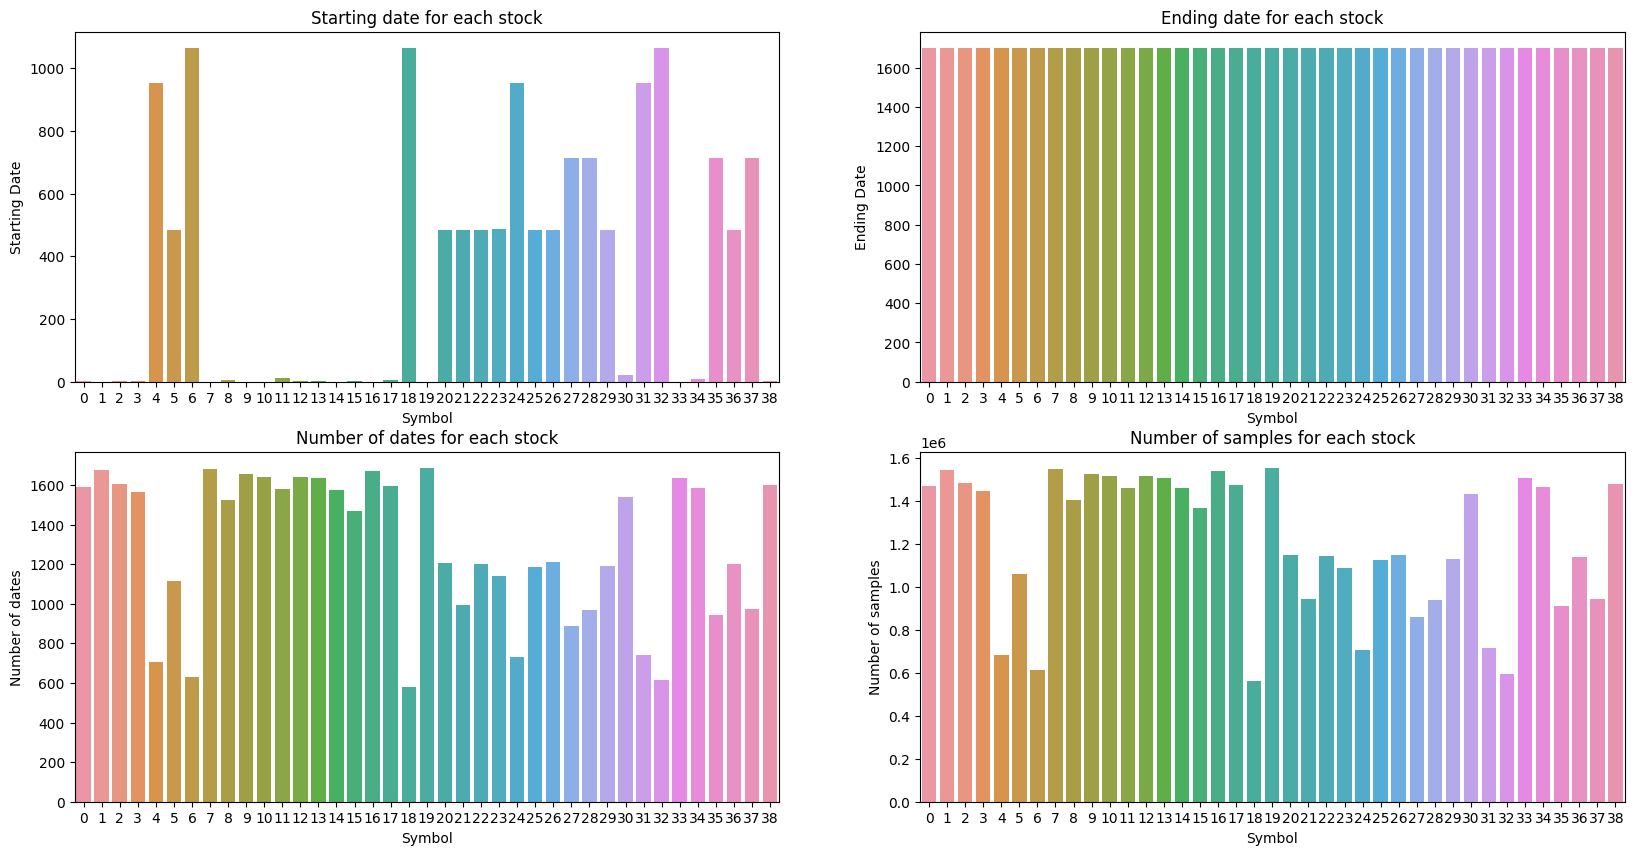

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

sns.barplot(ax=axes[0], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['min_date_id'].to_numpy())
axes[0].set_xlabel('Symbol')
axes[0].set_ylabel('Starting Date')
axes[0].set_title('Starting date for each stock')

sns.barplot(ax=axes[1], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['max_date_id'].to_numpy())
axes[1].set_xlabel('Symbol')
axes[1].set_ylabel('Ending Date')
axes[1].set_title('Ending date for each stock')

sns.barplot(ax=axes[2], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_dates'].to_numpy())
axes[2].set_xlabel('Symbol')
axes[2].set_ylabel('Number of dates')
axes[2].set_title('Number of dates for each stock')

sns.barplot(ax=axes[3], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_samples'].to_numpy())
axes[3].set_xlabel('Symbol')
axes[3].set_ylabel('Number of samples')
axes[3].set_title('Number of samples for each stock')

# Correlations

In [15]:
correlations = train_ds_sample.drop(['date_id', 'time_id', 'symbol_id', 'weight']).drop_nulls().corr()
correlations.head()

shape: (5, 88)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ feature_0 ┆ feature_0 ┆ feature_0 ┆ feature_0 ┆ … ┆ responder ┆ responder ┆ responder ┆ responde │
│ 0         ┆ 1         ┆ 2         ┆ 3         ┆   ┆ _5        ┆ _6        ┆ _7        ┆ r_8      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.0       ┆ 0.033604  ┆ 0.947702  ┆ 0.948515  ┆ … ┆ -0.051578 ┆ 0.003902  ┆ 0.0071    ┆ 0.001658 │
│ 0.033604  ┆ 1.0       ┆ -0.021292 ┆ -0.014472 ┆ … ┆ -0.012483 ┆ -0.01401  ┆ -0.008942 ┆ -0.01026 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ 0.947702  ┆ -0.021292 ┆ 1.0       ┆ 0.950083  ┆ … ┆ -0.050957 ┆ 0.005647  ┆ 0.008461  ┆ 0.00304  │
│ 0.948515  ┆ -0.014472 ┆ 0.950083  ┆ 1.0       ┆ … ┆ -0.051501 ┆ 0.004738  ┆ 0.007997  ┆ 0.002359 │
│ 0.003825  ┆ 0.284069  ┆ -0.03303  ┆ -0.010727 ┆ … ┆ -0.023706 ┆ -0.034238 ┆ -0.019841 ┆ -0.03103 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

<Axes: >

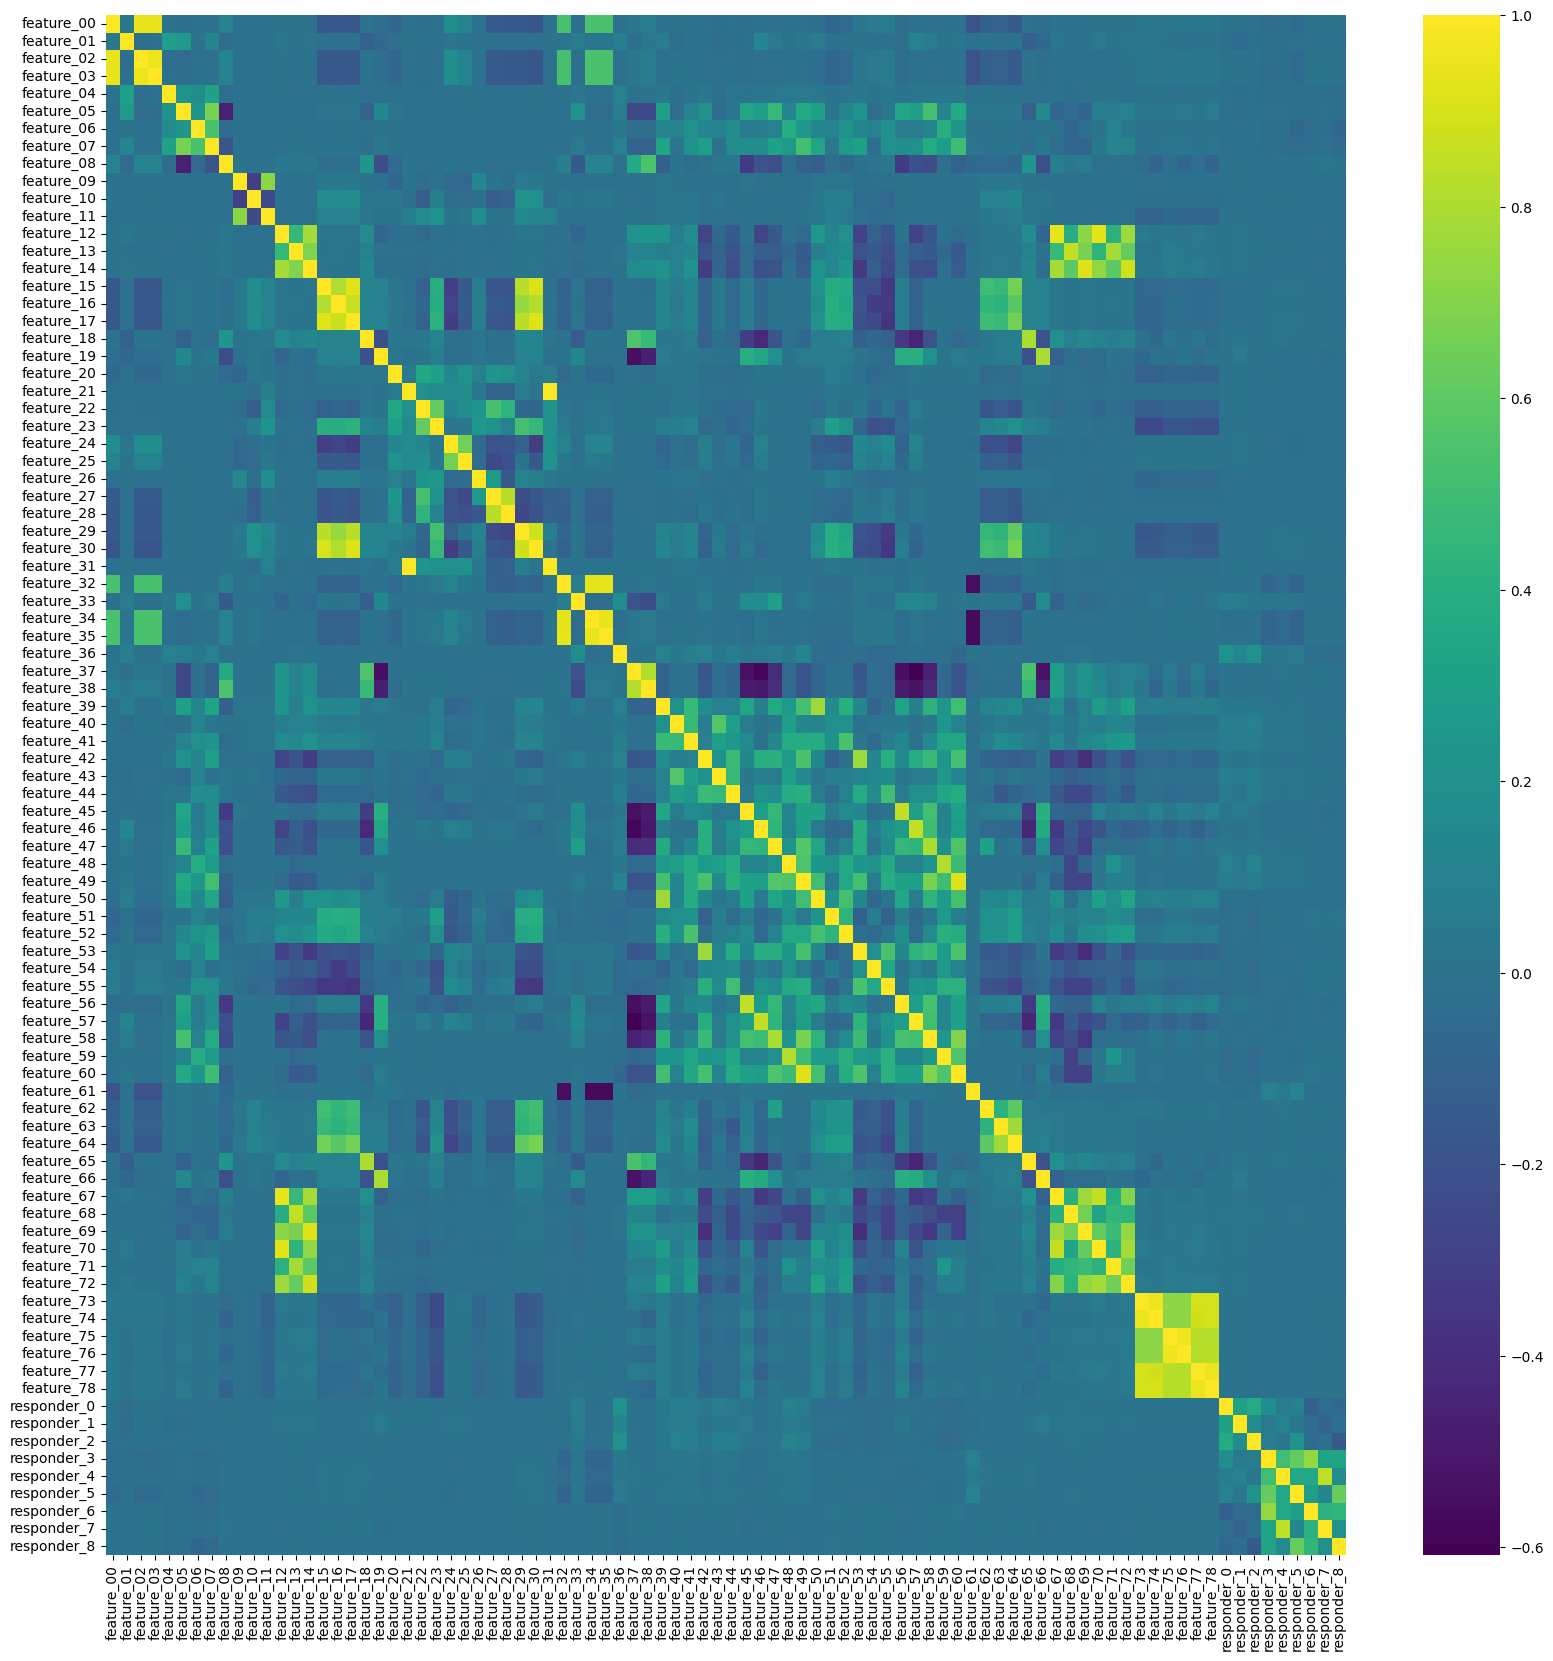

In [16]:
correlations = correlations.to_pandas()
correlations.index = correlations.columns.values

plt.figure(figsize=(20, 20))
sns.heatmap(correlations, cmap='viridis')

<Axes: >

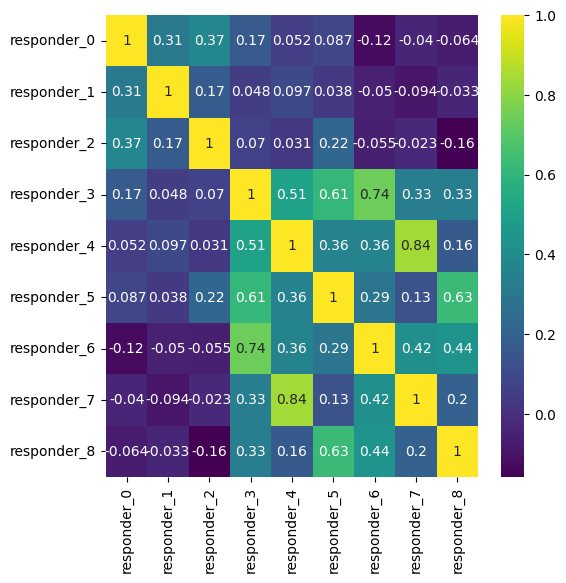

In [17]:
plt.figure(figsize=(6, 6))
sns.heatmap(correlations.iloc[-9:, -9:], cmap='viridis', annot=True)

Responder 6 and 3 are higly correlated

In [18]:
pl.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv')

shape: (9, 6)
┌─────────────┬───────┬───────┬───────┬───────┬───────┐
│ responder   ┆ tag_0 ┆ tag_1 ┆ tag_2 ┆ tag_3 ┆ tag_4 │
│ ---         ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str         ┆ bool  ┆ bool  ┆ bool  ┆ bool  ┆ bool  │
╞═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ responder_0 ┆ true  ┆ false ┆ true  ┆ false ┆ false │
│ responder_1 ┆ true  ┆ false ┆ false ┆ true  ┆ false │
│ responder_2 ┆ true  ┆ true  ┆ false ┆ false ┆ false │
│ responder_3 ┆ false ┆ false ┆ true  ┆ false ┆ true  │
│ responder_4 ┆ false ┆ false ┆ false ┆ true  ┆ true  │
│ responder_5 ┆ false ┆ true  ┆ false ┆ false ┆ true  │
│ responder_6 ┆ false ┆ false ┆ true  ┆ false ┆ false │
│ responder_7 ┆ false ┆ false ┆ false ┆ true  ┆ false │
│ responder_8 ┆ false ┆ true  ┆ false ┆ false ┆ false │
└─────────────┴───────┴───────┴───────┴───────┴───────┘

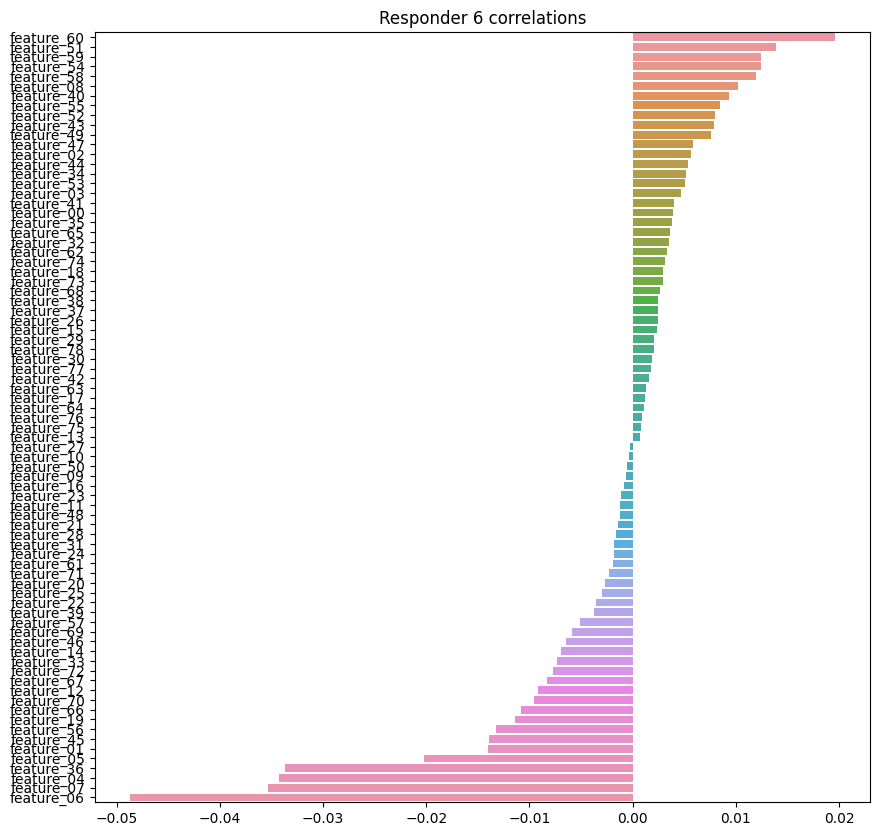

In [19]:
responder_6_correlations = correlations['responder_6'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_6_correlations.index, x=responder_6_correlations.values)
plt.title('Responder 6 correlations');

Correlation is higher in responder 3

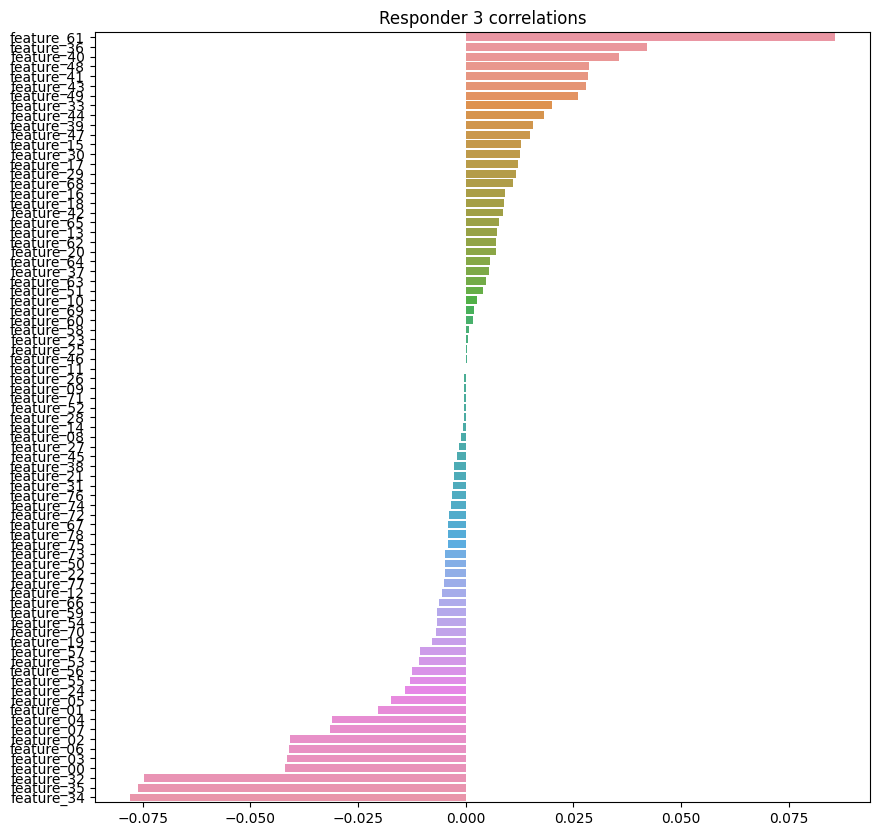

In [20]:
responder_3_correlations = correlations['responder_3'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_3_correlations.index, x=responder_3_correlations.values)
plt.title('Responder 3 correlations');

# Responders

In [21]:
RESPONDERS = [f'responder_{i}' for i in range(9)]

In [22]:
stock_1_responders = responders.filter(pl.col('symbol_id') == 1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

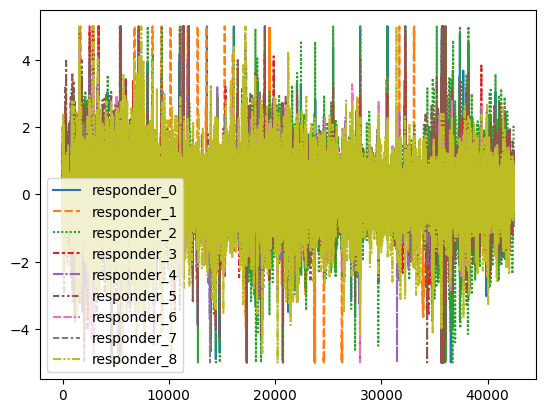

In [23]:
sns.lineplot(stock_1_responders.filter(pl.col('date_id') < 50).to_pandas()[RESPONDERS])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

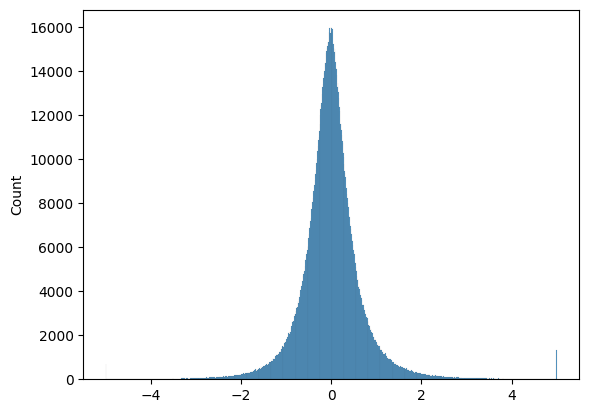

In [24]:
sns.histplot(stock_1_responders['responder_6'].to_numpy())

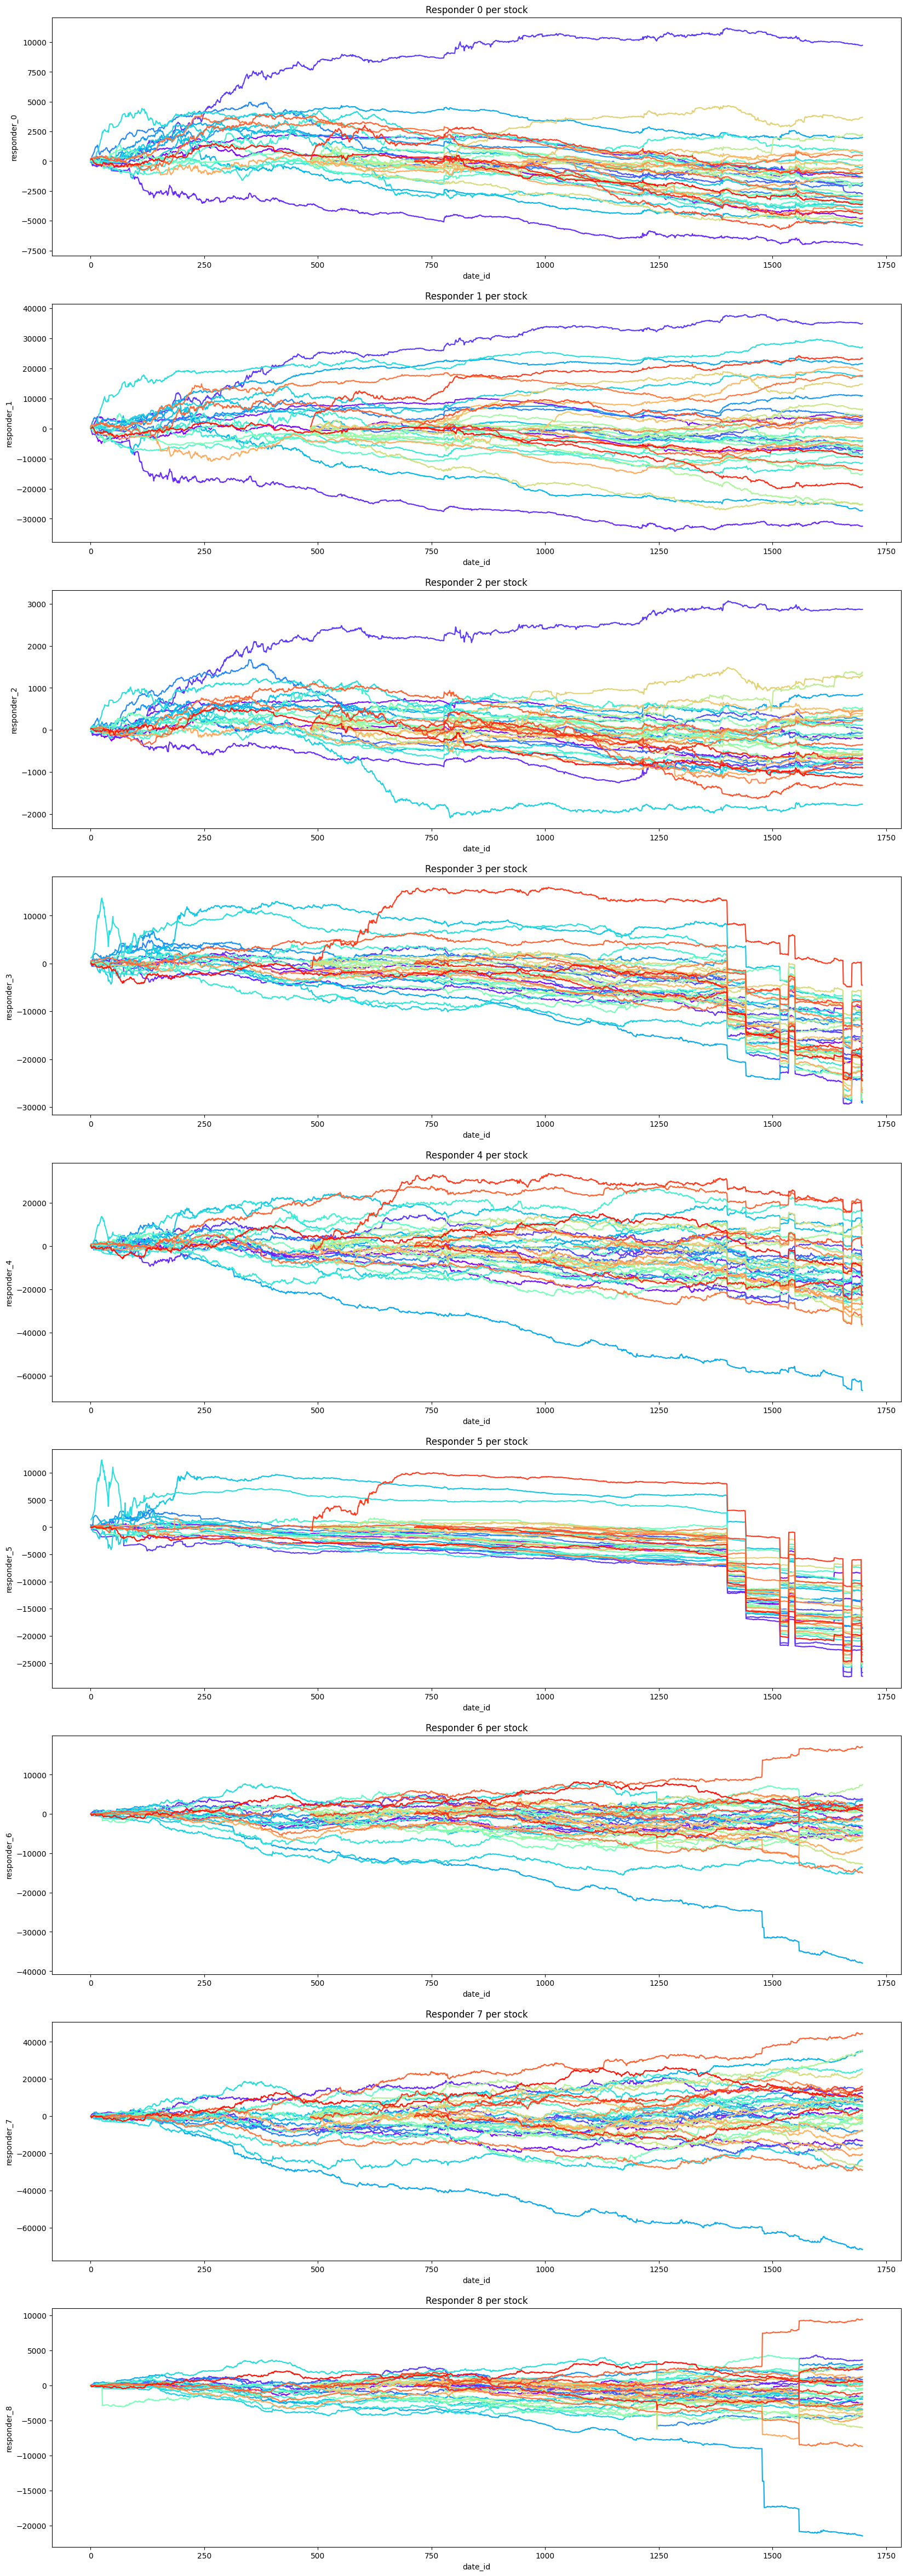

In [25]:
from matplotlib import cm

daily_responders = responders.group_by(['date_id', 'symbol_id']).agg(pl.col(RESPONDERS).sum())

colors = [cm.rainbow(i / 39)[:3] for i in range(39)]
fig, axes = plt.subplots(9, 1, figsize=(20, 60))

for i in range(9):
    for j in range(39):
        stock_data = daily_responders.filter(pl.col('symbol_id') == j).sort('date_id')
        axes[i].plot(stock_data['date_id'].to_numpy(), stock_data[f'responder_{i}'].to_numpy().cumsum(), color=colors[j])
    axes[i].set_xlabel('date_id')
    axes[i].set_ylabel(f'responder_{i}')
    axes[i].set_title(f'Responder {i} per stock')
    
plt.show()

In [26]:
time_responders = responders.group_by(['date_id', 'time_id']).agg(pl.col(RESPONDERS).sum())
time_responders.head()

shape: (5, 11)
┌─────────┬─────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ responder_ ┆ responder_ ┆ … ┆ responder_ ┆ responder ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ 0          ┆ 1          ┆   ┆ 5          ┆ _6        ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│         ┆         ┆ f32        ┆ f32        ┆   ┆ f32        ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪═════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 1100    ┆ 173     ┆ 0.804954   ┆ -1.157155  ┆ … ┆ 9.946108   ┆ 7.406392  ┆ -10.19961 ┆ 14.362967 │
│         ┆         ┆            ┆            ┆   ┆            ┆           ┆ 2         ┆           │
│ 147     ┆ 518     ┆ -0.738303  ┆ -0.499519  ┆ … ┆ 1.74874    ┆ 4.935616  ┆ 2.910937  ┆ 2.786277  │
│ 913     ┆ 467     ┆ -0.327039  ┆ -1.261117  ┆ … ┆ 0.653871   ┆ 4.405765  ┆ 8.818823  ┆ 0.525606  │
│ 1325    ┆ 548     ┆ 1.20806    ┆ -5.637695  ┆ … ┆ 2.753455   ┆ 11.096146 ┆ 8.602699  ┆ 2.785986  │
│ 236     ┆ 106     ┆ 3.786871   ┆ 0.723916   ┆ … ┆ 4.86946    ┆ 1.43975   ┆ 2.601421  ┆ 5.669126  │
└─────────┴─────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

Responder 6 is not zero-sum at the same time (not normalized w.r.t. the market)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

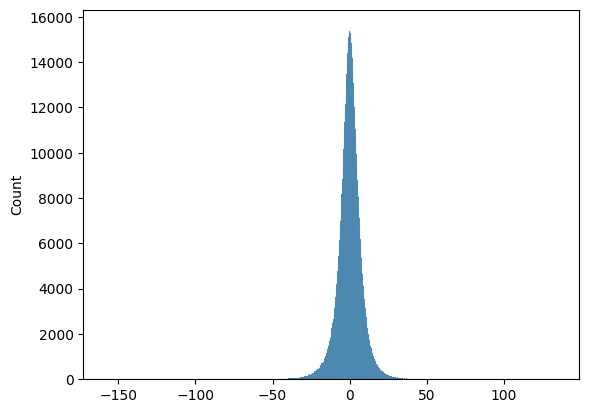

In [27]:
sns.histplot(time_responders['responder_6'].to_numpy())